Robust linear model estimation using RANSAC

Estimated coefficients (true, linear regression, RANSAC):
82.1903908407869 [54.17236387] [82.08533159]


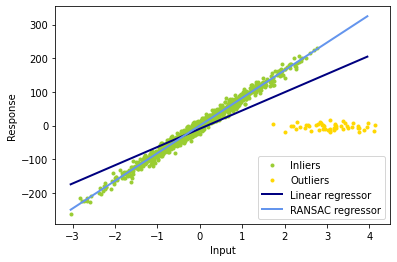

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn import linear_model, datasets


n_samples = 1000
n_outliers = 50


X, y, coef = datasets.make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=10,
                                      coef=True, random_state=0)

# Add outlier data
np.random.seed(0)
X[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)

# Fit line using all data
lr = linear_model.LinearRegression()
lr.fit(X, y)

# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac.predict(line_X)

# Compare estimated coefficients
print("Estimated coefficients (true, linear regression, RANSAC):")
print(coef, lr.coef_, ransac.estimator_.coef_)

lw = 2
plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
            label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.',
            label='Outliers')
plt.plot(line_X, line_y, color='navy', linewidth=lw, label='Linear regressor')
plt.plot(line_X, line_y_ransac, color='cornflowerblue', linewidth=lw,
         label='RANSAC regressor')
plt.legend(loc='lower right')
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()

Robust linear estimator fitting

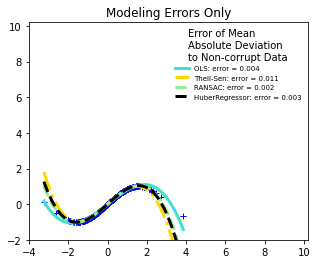

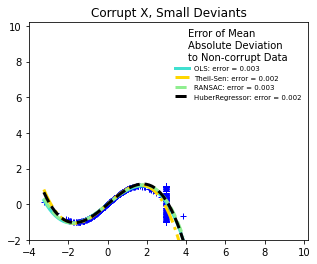

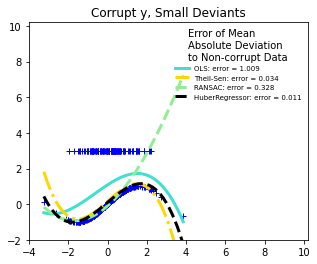

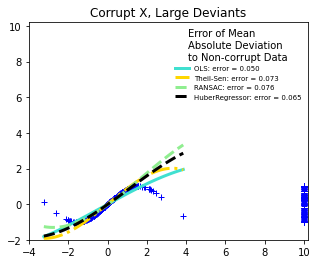

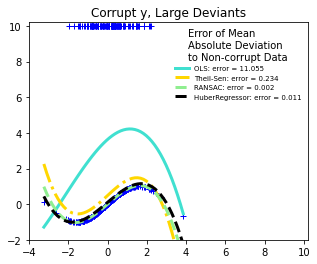

In [2]:
from matplotlib import pyplot as plt
import numpy as np

from sklearn.linear_model import (
    LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

np.random.seed(42)

X = np.random.normal(size=400)
y = np.sin(X)
# Make sure that it X is 2D
X = X[:, np.newaxis]

X_test = np.random.normal(size=200)
y_test = np.sin(X_test)
X_test = X_test[:, np.newaxis]

y_errors = y.copy()
y_errors[::3] = 3

X_errors = X.copy()
X_errors[::3] = 3

y_errors_large = y.copy()
y_errors_large[::3] = 10

X_errors_large = X.copy()
X_errors_large[::3] = 10

estimators = [('OLS', LinearRegression()),
              ('Theil-Sen', TheilSenRegressor(random_state=42)),
              ('RANSAC', RANSACRegressor(random_state=42)),
              ('HuberRegressor', HuberRegressor())]
colors = {'OLS': 'turquoise', 'Theil-Sen': 'gold',
          'RANSAC': 'lightgreen', 'HuberRegressor': 'black'}
linestyle = {'OLS': '-', 'Theil-Sen': '-.', 'RANSAC': '--', 'HuberRegressor': '--'}
lw = 3

x_plot = np.linspace(X.min(), X.max())
for title, this_X, this_y in [
        ('Modeling Errors Only', X, y),
        ('Corrupt X, Small Deviants', X_errors, y),
        ('Corrupt y, Small Deviants', X, y_errors),
        ('Corrupt X, Large Deviants', X_errors_large, y),
        ('Corrupt y, Large Deviants', X, y_errors_large)]:
    plt.figure(figsize=(5, 4))
    plt.plot(this_X[:, 0], this_y, 'b+')

    for name, estimator in estimators:
        model = make_pipeline(PolynomialFeatures(3), estimator)
        model.fit(this_X, this_y)
        mse = mean_squared_error(model.predict(X_test), y_test)
        y_plot = model.predict(x_plot[:, np.newaxis])
        plt.plot(x_plot, y_plot, color=colors[name], linestyle=linestyle[name],
                 linewidth=lw, label='%s: error = %.3f' % (name, mse))

    legend_title = 'Error of Mean\nAbsolute Deviation\nto Non-corrupt Data'
    legend = plt.legend(loc='upper right', frameon=False, title=legend_title,
                        prop=dict(size='x-small'))
    plt.xlim(-4, 10.2)
    plt.ylim(-2, 10.2)
    plt.title(title)
plt.show()

Theil-Sen Regression

Automatically created module for IPython interactive environment


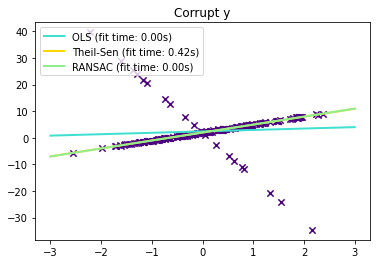

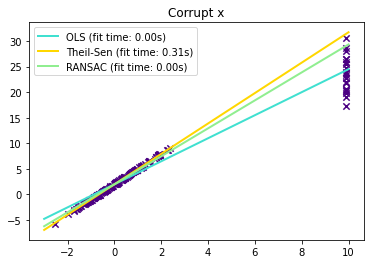

In [3]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, TheilSenRegressor
from sklearn.linear_model import RANSACRegressor

print(__doc__)

estimators = [('OLS', LinearRegression()),
              ('Theil-Sen', TheilSenRegressor(random_state=42)),
              ('RANSAC', RANSACRegressor(random_state=42)), ]
colors = {'OLS': 'turquoise', 'Theil-Sen': 'gold', 'RANSAC': 'lightgreen'}
lw = 2

# #############################################################################
# Outliers only in the y direction

np.random.seed(0)
n_samples = 200
# Linear model y = 3*x + N(2, 0.1**2)
x = np.random.randn(n_samples)
w = 3.
c = 2.
noise = 0.1 * np.random.randn(n_samples)
y = w * x + c + noise
# 10% outliers
y[-20:] += -20 * x[-20:]
X = x[:, np.newaxis]

plt.scatter(x, y, color='indigo', marker='x', s=40)
line_x = np.array([-3, 3])
for name, estimator in estimators:
    t0 = time.time()
    estimator.fit(X, y)
    elapsed_time = time.time() - t0
    y_pred = estimator.predict(line_x.reshape(2, 1))
    plt.plot(line_x, y_pred, color=colors[name], linewidth=lw,
             label='%s (fit time: %.2fs)' % (name, elapsed_time))

plt.axis('tight')
plt.legend(loc='upper left')
plt.title("Corrupt y")

# #############################################################################
# Outliers in the X direction

np.random.seed(0)
# Linear model y = 3*x + N(2, 0.1**2)
x = np.random.randn(n_samples)
noise = 0.1 * np.random.randn(n_samples)
y = 3 * x + 2 + noise
# 10% outliers
x[-20:] = 9.9
y[-20:] += 22
X = x[:, np.newaxis]

plt.figure()
plt.scatter(x, y, color='indigo', marker='x', s=40)

line_x = np.array([-3, 10])
for name, estimator in estimators:
    t0 = time.time()
    estimator.fit(X, y)
    elapsed_time = time.time() - t0
    y_pred = estimator.predict(line_x.reshape(2, 1))
    plt.plot(line_x, y_pred, color=colors[name], linewidth=lw,
             label='%s (fit time: %.2fs)' % (name, elapsed_time))

plt.axis('tight')
plt.legend(loc='upper left')
plt.title("Corrupt x")
plt.show()

In [5]:
#Robust linear estimator fitting

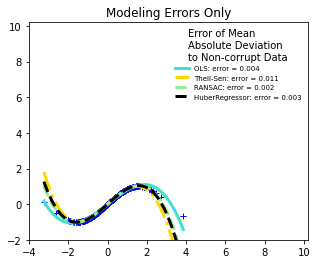

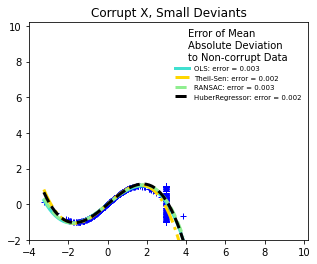

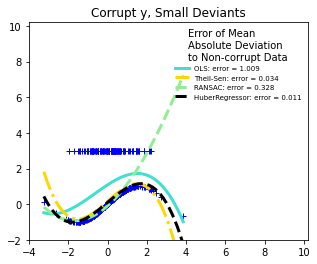

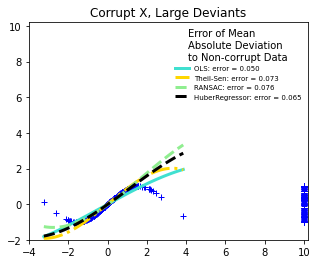

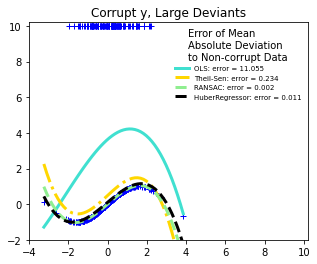

In [6]:
from matplotlib import pyplot as plt
import numpy as np

from sklearn.linear_model import (
    LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

np.random.seed(42)

X = np.random.normal(size=400)
y = np.sin(X)
# Make sure that it X is 2D
X = X[:, np.newaxis]

X_test = np.random.normal(size=200)
y_test = np.sin(X_test)
X_test = X_test[:, np.newaxis]

y_errors = y.copy()
y_errors[::3] = 3

X_errors = X.copy()
X_errors[::3] = 3

y_errors_large = y.copy()
y_errors_large[::3] = 10

X_errors_large = X.copy()
X_errors_large[::3] = 10

estimators = [('OLS', LinearRegression()),
              ('Theil-Sen', TheilSenRegressor(random_state=42)),
              ('RANSAC', RANSACRegressor(random_state=42)),
              ('HuberRegressor', HuberRegressor())]
colors = {'OLS': 'turquoise', 'Theil-Sen': 'gold',
          'RANSAC': 'lightgreen', 'HuberRegressor': 'black'}
linestyle = {'OLS': '-', 'Theil-Sen': '-.', 'RANSAC': '--', 'HuberRegressor': '--'}
lw = 3

x_plot = np.linspace(X.min(), X.max())
for title, this_X, this_y in [
        ('Modeling Errors Only', X, y),
        ('Corrupt X, Small Deviants', X_errors, y),
        ('Corrupt y, Small Deviants', X, y_errors),
        ('Corrupt X, Large Deviants', X_errors_large, y),
        ('Corrupt y, Large Deviants', X, y_errors_large)]:
    plt.figure(figsize=(5, 4))
    plt.plot(this_X[:, 0], this_y, 'b+')

    for name, estimator in estimators:
        model = make_pipeline(PolynomialFeatures(3), estimator)
        model.fit(this_X, this_y)
        mse = mean_squared_error(model.predict(X_test), y_test)
        y_plot = model.predict(x_plot[:, np.newaxis])
        plt.plot(x_plot, y_plot, color=colors[name], linestyle=linestyle[name],
                 linewidth=lw, label='%s: error = %.3f' % (name, mse))

    legend_title = 'Error of Mean\nAbsolute Deviation\nto Non-corrupt Data'
    legend = plt.legend(loc='upper right', frameon=False, title=legend_title,
                        prop=dict(size='x-small'))
    plt.xlim(-4, 10.2)
    plt.ylim(-2, 10.2)
    plt.title(title)
plt.show()

Theil-Sen Regression

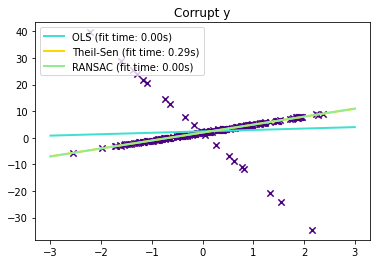

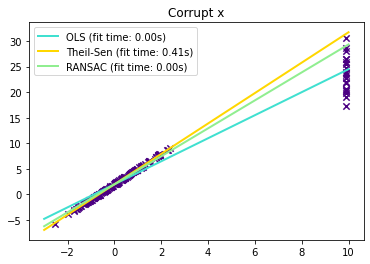

In [7]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, TheilSenRegressor
from sklearn.linear_model import RANSACRegressor

estimators = [('OLS', LinearRegression()),
              ('Theil-Sen', TheilSenRegressor(random_state=42)),
              ('RANSAC', RANSACRegressor(random_state=42)), ]
colors = {'OLS': 'turquoise', 'Theil-Sen': 'gold', 'RANSAC': 'lightgreen'}
lw = 2

# #############################################################################
# Outliers only in the y direction

np.random.seed(0)
n_samples = 200
# Linear model y = 3*x + N(2, 0.1**2)
x = np.random.randn(n_samples)
w = 3.
c = 2.
noise = 0.1 * np.random.randn(n_samples)
y = w * x + c + noise
# 10% outliers
y[-20:] += -20 * x[-20:]
X = x[:, np.newaxis]

plt.scatter(x, y, color='indigo', marker='x', s=40)
line_x = np.array([-3, 3])
for name, estimator in estimators:
    t0 = time.time()
    estimator.fit(X, y)
    elapsed_time = time.time() - t0
    y_pred = estimator.predict(line_x.reshape(2, 1))
    plt.plot(line_x, y_pred, color=colors[name], linewidth=lw,
             label='%s (fit time: %.2fs)' % (name, elapsed_time))

plt.axis('tight')
plt.legend(loc='upper left')
plt.title("Corrupt y")

# #############################################################################
# Outliers in the X direction

np.random.seed(0)
# Linear model y = 3*x + N(2, 0.1**2)
x = np.random.randn(n_samples)
noise = 0.1 * np.random.randn(n_samples)
y = 3 * x + 2 + noise
# 10% outliers
x[-20:] = 9.9
y[-20:] += 22
X = x[:, np.newaxis]

plt.figure()
plt.scatter(x, y, color='indigo', marker='x', s=40)

line_x = np.array([-3, 10])
for name, estimator in estimators:
    t0 = time.time()
    estimator.fit(X, y)
    elapsed_time = time.time() - t0
    y_pred = estimator.predict(line_x.reshape(2, 1))
    plt.plot(line_x, y_pred, color=colors[name], linewidth=lw,
             label='%s (fit time: %.2fs)' % (name, elapsed_time))

plt.axis('tight')
plt.legend(loc='upper left')
plt.title("Corrupt x")
plt.show()

HuberRegressor vs Ridge on dataset with strong outliers

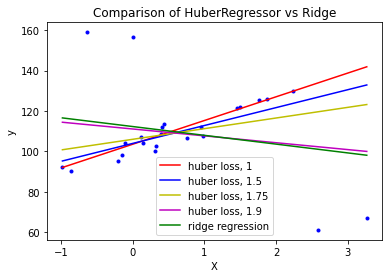

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_regression
from sklearn.linear_model import HuberRegressor, Ridge

# Generate toy data.
rng = np.random.RandomState(0)
X, y = make_regression(n_samples=20, n_features=1, random_state=0, noise=4.0,
                       bias=100.0)

# Add four strong outliers to the dataset.
X_outliers = rng.normal(0, 0.5, size=(4, 1))
y_outliers = rng.normal(0, 2.0, size=4)
X_outliers[:2, :] += X.max() + X.mean() / 4.
X_outliers[2:, :] += X.min() - X.mean() / 4.
y_outliers[:2] += y.min() - y.mean() / 4.
y_outliers[2:] += y.max() + y.mean() / 4.
X = np.vstack((X, X_outliers))
y = np.concatenate((y, y_outliers))
plt.plot(X, y, 'b.')

# Fit the huber regressor over a series of epsilon values.
colors = ['r-', 'b-', 'y-', 'm-']

x = np.linspace(X.min(), X.max(), 7)
epsilon_values = [1, 1.5, 1.75, 1.9]
for k, epsilon in enumerate(epsilon_values):
    huber = HuberRegressor(alpha=0.0, epsilon=epsilon)
    huber.fit(X, y)
    coef_ = huber.coef_ * x + huber.intercept_
    plt.plot(x, coef_, colors[k], label="huber loss, %s" % epsilon)

# Fit a ridge regressor to compare it to huber regressor.
ridge = Ridge(alpha=0.0, random_state=0)
ridge.fit(X, y)
coef_ridge = ridge.coef_
coef_ = ridge.coef_ * x + ridge.intercept_
plt.plot(x, coef_, 'g-', label="ridge regression")

plt.title("Comparison of HuberRegressor vs Ridge")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(loc=0)
plt.show()